미리 학습된 모델을 사물의 분류 갯수에 맞추어진 top 을 제외하고 불러와 원하는 데이터셋에 특화시켜 학습하는 방법을 알아봅시다. 일단 원하는 데이터셋을 불러옵니다.

train_images <class 'numpy.ndarray'> (50000, 32, 32, 3) uint8
train_labels <class 'numpy.ndarray'> (50000, 1) uint8
test_images <class 'numpy.ndarray'> (10000, 32, 32, 3) uint8
test_labels <class 'numpy.ndarray'> (10000, 1) uint8


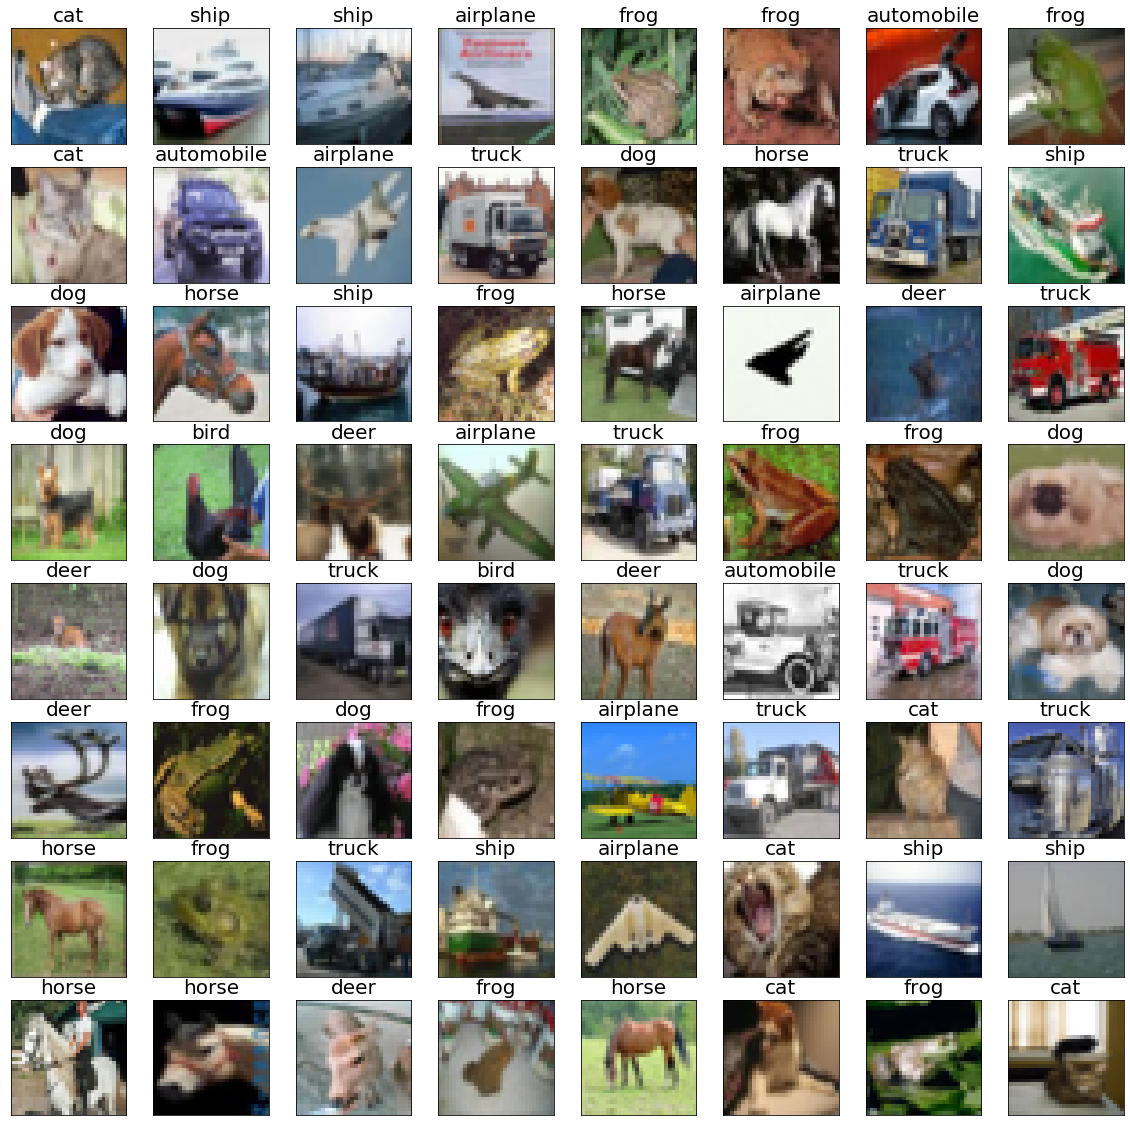

In [1]:
from tensorflow.keras import datasets, layers, models, utils, optimizers
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print( 'train_images', type(train_images), train_images.shape, train_images.dtype )
print( 'train_labels', type(train_labels), train_labels.shape, train_labels.dtype )
print( 'test_images', type(test_images), test_images.shape, test_images.dtype )
print( 'test_labels', type(test_labels), test_labels.shape, test_labels.dtype )

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck' ]

plt.figure( figsize=(20,20) )
for i in range(0, 8*8):
    plt.subplot(8,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( class_names[test_labels[i][0]], {'fontsize':20} )
    plt.imshow( test_images[i] )

원하는 모델을 top 을 제외하고 불러오면서 입력 이미지의 크기를 설정해줍니다.

In [2]:
#from tensorflow.keras.applications.resnet50 import ResNet50 as pre_model
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#from tensorflow.keras.applications.xception import Xception as pre_model
#from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

from tensorflow.keras.applications.vgg16 import VGG16 as pre_model
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

#from tensorflow.keras.applications.vgg19 import VGG19 as pre_model
#from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

#from tensorflow.keras.applications.inception_v3 import InceptionV3 as pre_model
#from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

base_model = pre_model( weights='imagenet', include_top=False, input_shape=(64,64,3) )
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

학습 이미지를 모델의 입력크기에 맞추어 리사이즈 해주고 그 이미지가 전처리되면서 손상되는것을 막기위해 복사를 하고 그 복사한 이미지로 전처리를 해줍니다.

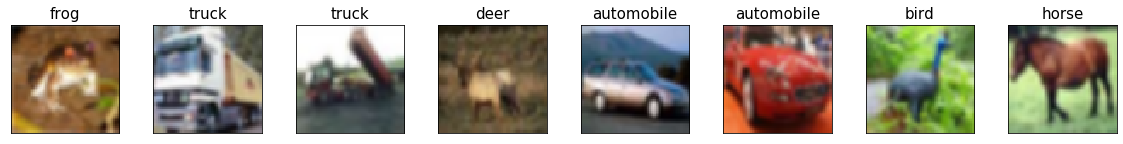

In [3]:
# pip install scikit-image
from skimage.transform import resize

# Memory error might occur
#train_images_resized = resize(train_images, (train_images.shape[0], 64, 64, 3),
#                              preserve_range=True, anti_aliasing=True)

Ntrain = train_images.shape[0]
train_images_resized = np.zeros((Ntrain,64,64,3), dtype=np.float32 )
for i in range(Ntrain):
    train_images_resized[i] = resize(train_images[i], (64, 64, 3),
                                     preserve_range=True, anti_aliasing=True)

plt.figure(figsize=(20,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( class_names[train_labels[i][0]], {'fontsize':15} )
    plt.imshow( train_images_resized[i].astype(np.uint8) )
plt.show()

train_x = train_images_resized.copy();
train_x = preprocess_input(train_x)

검증 이미지에 대해서도 같은 작업을 해줍니다.

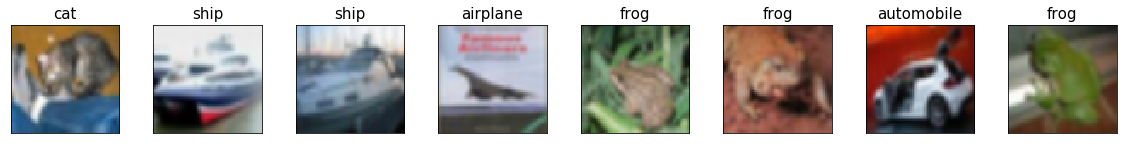

In [4]:
# Memory error might occur
#test_images_resized = resize(test_images, (test_images.shape[0], 64, 64, 3),
#                             preserve_range=True, anti_aliasing=True)

Ntest = test_images.shape[0]
test_images_resized = np.zeros((Ntest,64,64,3), dtype=np.float32 )
for i in range(Ntest):
    test_images_resized[i] = resize(test_images[i], (64, 64, 3),
                                    preserve_range=True, anti_aliasing=True)

plt.figure(figsize=(20,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.xticks([]); plt.yticks([])
    plt.title( class_names[test_labels[i][0]], {'fontsize':15} )
    plt.imshow( test_images_resized[i].astype(np.uint8) )
plt.show()

test_x = test_images_resized.copy();
test_x = preprocess_input(test_x)

레이블을 전처리해줍니다.

In [5]:
num_classes = 10

print( 'test_labels', test_labels.shape, test_labels.dtype )
print( 'test_labels[0] =', test_labels[0] )

train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes)

print( 'test_y', test_y.shape, test_y.dtype )
print( 'test_y[0] =', test_y[0] )

test_labels (10000, 1) uint8
test_labels[0] = [3]
test_y (10000, 10) float32
test_y[0] = [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


top 없이 불러온 base_model 에 우리가 원하는 데이터셋을 분류하는 레이어들을 추가합니다.

In [6]:
y = base_model.output
y = layers.GlobalAveragePooling2D()(y)
y = layers.Dense(128, activation='relu')(y)
y = layers.Dropout(0.5)(y)
y = layers.Dense(num_classes, activation='softmax')(y)

model = models.Model( base_model.input, y)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

일단 base_model 의 층들의 웨이트를 고정시키고 새로 추가한 층들만 원하는 데이터셋으로 학습을 합니다.

Train on 40000 samples, validate on 10000 samples
Epoch 1/4
40000/40000 [==============================] - 59s 1ms/sample - loss: 1.6794 - accuracy: 0.5589 - val_loss: 0.9242 - val_accuracy: 0.7054
Epoch 2/4
40000/40000 [==============================] - 57s 1ms/sample - loss: 1.1271 - accuracy: 0.6740 - val_loss: 0.9323 - val_accuracy: 0.7301
Epoch 3/4
40000/40000 [==============================] - 57s 1ms/sample - loss: 1.1116 - accuracy: 0.6899 - val_loss: 0.9613 - val_accuracy: 0.7372
Epoch 4/4
40000/40000 [==============================] - 57s 1ms/sample - loss: 1.1072 - accuracy: 0.7035 - val_loss: 1.0272 - val_accuracy: 0.7404


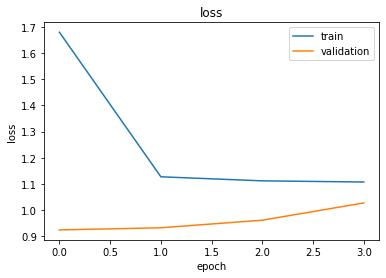

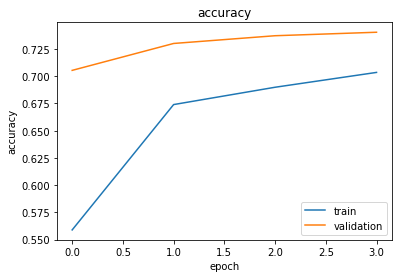

10000/10000 [==============================] - 10s 999us/sample - loss: 1.0440 - accuracy: 0.7334
[loss, accuracy] = [1.0439962246894836, 0.7334]


In [7]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit( train_x, train_y, batch_size=32, epochs=4, validation_split=0.2 )

from modules.plot_history import plot_history
plot_history(hist, 'loss')
plot_history(hist, 'accuracy')

evaluation = model.evaluate( test_x, test_y, batch_size=128 )
print( "[loss, accuracy] =", evaluation )

추가로 base_model 의 마지막 몇개 convolution 층들도 같이 학습을 합니다. 그러면 정확도가 좀 더 향상됩니다.

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 global_average_pooling2d
20 dense
21 dropout
22 dense_1
Train on 45000 samples, validate on 5000 samples
Epoch 1/10
45000/45000 [==============================] - 113s 3ms/sample - loss: 0.7785 - accuracy: 0.7599 - val_loss: 0.4798 - val_accuracy: 0.8462
Epoch 2/10
45000/45000 [==============================] - 111s 2ms/sample - loss: 0.4514 - accuracy: 0.8541 - val_loss: 0.4087 - val_accuracy: 0.8708
Epoch 3/10
45000/45000 [==============================] - 111s 2ms/sample - loss: 0.3182 - accuracy: 0.8926 - val_loss: 0.3900 - val_accuracy: 0.8838
Epoch 4/10
45000/45000 [==============================] - 111s 2ms/sample - loss: 0.2354 - accuracy: 0.9183 - val_loss: 0.3775 - val_accuracy: 0.8918
Epoch 5/

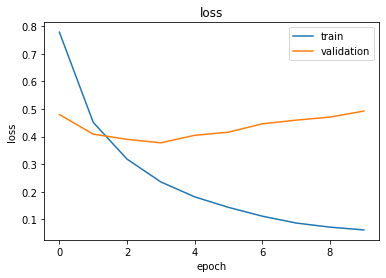

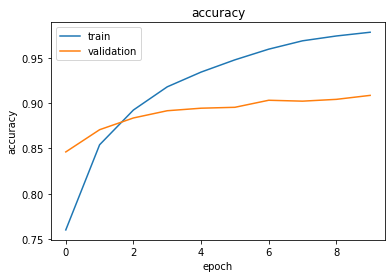

10000/10000 [==============================] - 9s 871us/sample - loss: 0.5532 - accuracy: 0.8947
[loss, accuracy] = [0.5531712297439575, 0.8947]


In [8]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True
    
model.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit( train_x, train_y, batch_size=32, epochs=10, validation_split=0.1 )

from modules.plot_history import plot_history
plot_history(hist, 'loss')
plot_history(hist, 'accuracy')

evaluation = model.evaluate( test_x, test_y, batch_size=128 )
print( "[loss, accuracy] =", evaluation )